In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
latent_dim = 128
condition_dim = 512  
input_dim = 224 * 224 * 3  
num_epochs = 50
learning_rate = 1e-4

model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)

train_dir = "./coco/train"
val_dir = "./coco/val"
# image_dir = f"{data_dir}/train/data"
train_ann_file = "coco/anotataions/captions_train2017.json"
val_ann_file = "coco/anotataions/captions_val2017.json"


New coco dataset

In [17]:
import os
from torch.utils.data import Dataset
from PIL import Image
import torch

class COCOCaptionDataset(Dataset):
    def __init__(self, coco, image_dir, transform=None, subset_fraction=1.0):
        """
        A PyTorch Dataset class for COCO captions with filtered images based on available files.
        
        Args:
            coco: COCO API object for loading annotations.
            image_dir (str): Directory containing the image files.
            transform: Optional transformation to be applied on an image.
            subset_fraction (float): Fraction of the dataset to use.
        """
        self.coco = coco
        self.image_dir = image_dir
        self.transform = transform
        
        # Filter image IDs to include only images with existing files in image_dir
        all_image_ids = list(coco.imgs.keys())
        self.image_ids = [
            image_id for image_id in all_image_ids
            if os.path.exists(f"{image_dir}/{coco.imgs[image_id]['file_name']}")
        ]
        
        # Apply subset fraction
        subset_size = int(len(self.image_ids) * subset_fraction)
        self.image_ids = self.image_ids[:subset_size]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        """
        Get a single data sample.

        Args:
            idx (int): Index of the sample.

        Returns:
            image (PIL Image): Transformed image.
            text_features (torch.Tensor): Encoded text features from CLIP.
        """
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = f"{self.image_dir}/{image_info['file_name']}"
        
        # Load and transform the image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        # Get the caption annotations
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(ann_ids)
        caption = annotations[0]['caption']
        
        # Extract text features using the provided method
        text_features = self.extract_text_features(caption)
        
        return image, text_features

    def extract_text_features(self, text):
        """
        Extract text features using a pre-trained CLIP model.

        Args:
            text (str): Input text to encode.

        Returns:
            text_features (torch.Tensor): Encoded text features.
        """
        text_tokens = clip.tokenize([text]).to(device)
        with torch.no_grad():
            text_features = model_clip.encode_text(text_tokens)
        return text_features.squeeze(0)

In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 归一化
])


subset_fraction = 1.0

coco = COCO(train_ann_file)
dataset = COCOCaptionDataset(coco, train_dir, transform=transform, subset_fraction=subset_fraction)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)
print(len(dataset))
print(len(dataloader))

coco_val = COCO(val_ann_file)
val_dataset = COCOCaptionDataset(coco_val, val_dir, transform=transform, subset_fraction=subset_fraction)
val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0
)
print(len(val_dataset))
print(len(val_loader))


loading annotations into memory...
Done (t=0.55s)
creating index...
index created!
10020
157
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
4867
2434


In [19]:
# View a single sample
sample_image, sample_text_features = dataset[9]

print("Image shape:", sample_image.shape)
print("Text features shape:", sample_text_features.shape)

Image shape: torch.Size([3, 224, 224])
Text features shape: torch.Size([512])


In [20]:

# class COCOCaptionDataset(Dataset):
#     def __init__(self, coco, image_dir, transform=None, subset_fraction=1.0):
#         self.coco = coco
#         self.image_dir = image_dir
#         self.image_ids = list(coco.imgs.keys())
#         subset_size = int(len(self.image_ids) * subset_fraction)
#         self.image_ids = self.image_ids[:subset_size]
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_ids)

#     def __getitem__(self, idx):
#         image_id = self.image_ids[idx]
#         image_info = self.coco.loadImgs(image_id)[0]
#         image_path = f"{self.image_dir}/{image_info['file_name']}"
#         image = Image.open(image_path).convert("RGB")
#         if self.transform:
#             image = self.transform(image)
#         ann_ids = self.coco.getAnnIds(imgIds=image_id)
#         annotations = self.coco.loadAnns(ann_ids)
#         caption = annotations[0]['caption']
#         text_features = self.extract_text_features(caption)
#         return image, text_features

#     def extract_text_features(self, text):
#         text_tokens = clip.tokenize([text]).to(device)
#         with torch.no_grad():
#             text_features = model_clip.encode_text(text_tokens)
#         return text_features.squeeze(0)

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 归一化
# ])


# subset_fraction = 1.0
# dataset = COCOCaptionDataset(coco, image_dir, transform=transform, subset_fraction=subset_fraction)
# dataloader = DataLoader(
#     dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=0
# )

class Encoder(nn.Module):
    def __init__(self, latent_dim, condition_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3 + condition_dim, 32, kernel_size=3, stride=2, padding=1)  # 32x112x112
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # 64x56x56
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # 128x28x28
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # 256x14x14
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # 512x7x7
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(512 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(512 * 7 * 7, latent_dim)

    def forward(self, x, condition):
        batch_size = x.size(0)
        condition = condition.view(batch_size, -1, 1, 1)
        condition = condition.expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, condition], dim=1)
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, condition_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim, 1024)
        self.fc2 = nn.Linear(1024, 512 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)  # 14x14
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # 28x28
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)   # 56x56
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)    # 112x112
        self.deconv5 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)     # 224x224

    def forward(self, z, condition):
        z = torch.cat([z, condition], dim=1)
        h = F.leaky_relu(self.fc1(z))
        h = F.leaky_relu(self.fc2(h))
        h = h.view(h.size(0), 512, 7, 7)
        h = F.leaky_relu(self.deconv1(h))
        h = F.leaky_relu(self.deconv2(h))
        h = F.leaky_relu(self.deconv3(h))
        h = F.leaky_relu(self.deconv4(h))
        x_recon = torch.sigmoid(self.deconv5(h))  
        return x_recon



class CVAE(nn.Module):
    def __init__(self, latent_dim, condition_dim):
        super(CVAE, self).__init__()
        self.encoder = Encoder(latent_dim, condition_dim)
        self.decoder = Decoder(latent_dim, condition_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, condition):
        mu, logvar = self.encoder(x, condition)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, condition)
        return x_recon, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.BCELoss(reduction='sum')(recon_x, x)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

In [21]:

# model = CVAE(latent_dim=latent_dim, condition_dim=condition_dim).to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# model.train()
# for epoch in range(num_epochs):
#     train_loss = 0
#     start_time = time.time()
#     with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as pbar:
#         for batch_idx, (images, text_features) in enumerate(dataloader):
#             images, text_features = images.to(device), text_features.to(device)
#             # images = images * 0.5 + 0.5  
#             optimizer.zero_grad()
#             recon_batch, mu, logvar = model(images, text_features)
#             loss = loss_function(recon_batch, images, mu, logvar)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#             pbar.update(1)
#             pbar.set_postfix(loss=loss.item())
#     epoch_time = time.time() - start_time
#     print(f"Epoch [{epoch+1}/{num_epochs}] finished in {epoch_time:.2f}s, Loss: {train_loss / len(dataset):.4f}")


# model_path = "./model.pth"
# torch.save(model.state_dict(), model_path)
# print(f"Model saved to {model_path}")

In [22]:
# #

# # 
# model_path = "./model.pth"  

# model = CVAE(latent_dim=latent_dim, condition_dim=condition_dim).to(device)
# model.load_state_dict(torch.load(model_path))
# print(f"Model loaded from {model_path}")

# # train
# model.train()
# # optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# num_epochs = 30
# for epoch in range(num_epochs):
#     train_loss = 0
#     start_time = time.time()
#     with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as pbar:
#         for batch_idx, (images, text_features) in enumerate(dataloader):
#             images, text_features = images.to(device), text_features.to(device)
#             # images = images * 0.5 + 0.5  
#             optimizer.zero_grad()
#             recon_batch, mu, logvar = model(images, text_features)
#             loss = loss_function(recon_batch, images, mu, logvar)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#             pbar.update(1)
#             pbar.set_postfix(loss=loss.item())
#     epoch_time = time.time() - start_time
#     print(f"Epoch [{epoch+1}/{num_epochs}] finished in {epoch_time:.2f}s, Loss: {train_loss / len(dataset):.4f}")

# # save new model
# new_model_path = "./model_new.pth"
# torch.save(model.state_dict(), new_model_path)
# print(f"Model saved to {new_model_path}")

In [23]:
# 

# 
# model_path = "./model_new.pth"  

# model = CVAE(latent_dim=latent_dim, condition_dim=condition_dim).to(device)
# model.load_state_dict(torch.load(model_path))
# print(f"Model loaded from {model_path}")

# # train
# model.train()
# # optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# num_epochs = 20
# for epoch in range(num_epochs):
#     train_loss = 0
#     start_time = time.time()
#     with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as pbar:
#         for batch_idx, (images, text_features) in enumerate(dataloader):
#             images, text_features = images.to(device), text_features.to(device)
#             # images = images * 0.5 + 0.5  
#             optimizer.zero_grad()
#             recon_batch, mu, logvar = model(images, text_features)
#             loss = loss_function(recon_batch, images, mu, logvar)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#             pbar.update(1)
#             pbar.set_postfix(loss=loss.item())
#     epoch_time = time.time() - start_time
#     print(f"Epoch [{epoch+1}/{num_epochs}] finished in {epoch_time:.2f}s, Loss: {train_loss / len(dataset):.4f}")

# # save new model
# new_model_path = "./model_50.pth"
# torch.save(model.state_dict(), new_model_path)
# print(f"Model saved to {new_model_path}")

In [24]:
# 

# 
# model_path = "./model_50.pth"  

# model = CVAE(latent_dim=latent_dim, condition_dim=condition_dim).to(device)
# model.load_state_dict(torch.load(model_path))
# print(f"Model loaded from {model_path}")

# # train
# model.train()
# # optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# num_epochs = 50
# for epoch in range(num_epochs):
#     train_loss = 0
#     start_time = time.time()
#     with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as pbar:
#         for batch_idx, (images, text_features) in enumerate(dataloader):
#             images, text_features = images.to(device), text_features.to(device)
#             # images = images * 0.5 + 0.5  
#             optimizer.zero_grad()
#             recon_batch, mu, logvar = model(images, text_features)
#             loss = loss_function(recon_batch, images, mu, logvar)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#             pbar.update(1)
#             pbar.set_postfix(loss=loss.item())
#     epoch_time = time.time() - start_time
#     print(f"Epoch [{epoch+1}/{num_epochs}] finished in {epoch_time:.2f}s, Loss: {train_loss / len(dataset):.4f}")

# # save new model
# new_model_path = "./model_100.pth"
# torch.save(model.state_dict(), new_model_path)
# print(f"Model saved to {new_model_path}")

In [25]:
# #

# #
# model_path = "./model_100.pth"  

# model = CVAE(latent_dim=latent_dim, condition_dim=condition_dim).to(device)
# model.load_state_dict(torch.load(model_path))
# print(f"Model loaded from {model_path}")

# # train
# model.train()
# # optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# num_epochs = 50
# for epoch in range(num_epochs):
#     train_loss = 0
#     start_time = time.time()
#     with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as pbar:
#         for batch_idx, (images, text_features) in enumerate(dataloader):
#             images, text_features = images.to(device), text_features.to(device)
#             # images = images * 0.5 + 0.5  
#             optimizer.zero_grad()
#             recon_batch, mu, logvar = model(images, text_features)
#             loss = loss_function(recon_batch, images, mu, logvar)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#             pbar.update(1)
#             pbar.set_postfix(loss=loss.item())
#     epoch_time = time.time() - start_time
#     print(f"Epoch [{epoch+1}/{num_epochs}] finished in {epoch_time:.2f}s, Loss: {train_loss / len(dataset):.4f}")

# # save new model
# new_model_path = "./model_150.pth"
# torch.save(model.state_dict(), new_model_path)
# print(f"Model saved to {new_model_path}")

In [26]:
# # 

# #
# model_path = "./model_150.pth"  

# model = CVAE(latent_dim=latent_dim, condition_dim=condition_dim).to(device)
# model.load_state_dict(torch.load(model_path))
# print(f"Model loaded from {model_path}")

# # train
# model.train()
# # optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# num_epochs = 50
# for epoch in range(num_epochs):
#     train_loss = 0
#     start_time = time.time()
#     with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as pbar:
#         for batch_idx, (images, text_features) in enumerate(dataloader):
#             images, text_features = images.to(device), text_features.to(device)
#             # images = images * 0.5 + 0.5  
#             optimizer.zero_grad()
#             recon_batch, mu, logvar = model(images, text_features)
#             loss = loss_function(recon_batch, images, mu, logvar)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#             pbar.update(1)
#             pbar.set_postfix(loss=loss.item())
#     epoch_time = time.time() - start_time
#     print(f"Epoch [{epoch+1}/{num_epochs}] finished in {epoch_time:.2f}s, Loss: {train_loss / len(dataset):.4f}")

# # save new model
# new_model_path = "./model_200.pth"
# torch.save(model.state_dict(), new_model_path)
# print(f"Model saved to {new_model_path}")

In [27]:
# # 
# # 

# #
# model_path = "./model_200.pth"  

# model = CVAE(latent_dim=latent_dim, condition_dim=condition_dim).to(device)
# model.load_state_dict(torch.load(model_path))
# print(f"Model loaded from {model_path}")

# # train
# model.train()
# # optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 50
# for epoch in range(num_epochs):
#     train_loss = 0
#     start_time = time.time()
#     with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as pbar:
#         for batch_idx, (images, text_features) in enumerate(dataloader):
#             images, text_features = images.to(device), text_features.to(device)
#             # images = images * 0.5 + 0.5  
#             optimizer.zero_grad()
#             recon_batch, mu, logvar = model(images, text_features)
#             loss = loss_function(recon_batch, images, mu, logvar)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#             pbar.update(1)
#             pbar.set_postfix(loss=loss.item())
#     epoch_time = time.time() - start_time
#     print(f"Epoch [{epoch+1}/{num_epochs}] finished in {epoch_time:.2f}s, Loss: {train_loss / len(dataset):.4f}")

# # save new model
# new_model_path = "./model_250.pth"
# torch.save(model.state_dict(), new_model_path)
# print(f"Model saved to {new_model_path}")

In [28]:
# # 
# # 

# # 
# model_path = "./model_250.pth"  

# model = CVAE(latent_dim=latent_dim, condition_dim=condition_dim).to(device)
# model.load_state_dict(torch.load(model_path))
# print(f"Model loaded from {model_path}")

# # train
# model.train()
# # optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 50
# for epoch in range(num_epochs):
#     train_loss = 0
#     start_time = time.time()
#     with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as pbar:
#         for batch_idx, (images, text_features) in enumerate(dataloader):
#             images, text_features = images.to(device), text_features.to(device)
#             # images = images * 0.5 + 0.5  
#             optimizer.zero_grad()
#             recon_batch, mu, logvar = model(images, text_features)
#             loss = loss_function(recon_batch, images, mu, logvar)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#             pbar.update(1)
#             pbar.set_postfix(loss=loss.item())
#     epoch_time = time.time() - start_time
#     print(f"Epoch [{epoch+1}/{num_epochs}] finished in {epoch_time:.2f}s, Loss: {train_loss / len(dataset):.4f}")

# # save new model
# new_model_path = "./model_300.pth"
# torch.save(model.state_dict(), new_model_path)
# print(f"Model saved to {new_model_path}")

Model loaded successfully!
tensor([[-0.1183,  0.1780,  0.0839,  ...,  0.2954,  0.2471, -0.5693],
        [ 0.2815, -0.2198, -0.5210,  ...,  0.1992, -0.4402, -0.0656],
        [ 0.1393,  0.3345, -0.0787,  ..., -0.0303, -0.3706, -0.2408],
        [-0.3186,  0.1727, -0.0447,  ..., -0.1635, -0.3220, -0.1595],
        [-0.4172,  0.1592, -0.0795,  ...,  0.0464, -0.2427,  0.3286]],
       device='cuda:0', dtype=torch.float16)
torch.Size([5, 128])
torch.Size([5, 3, 224, 224])


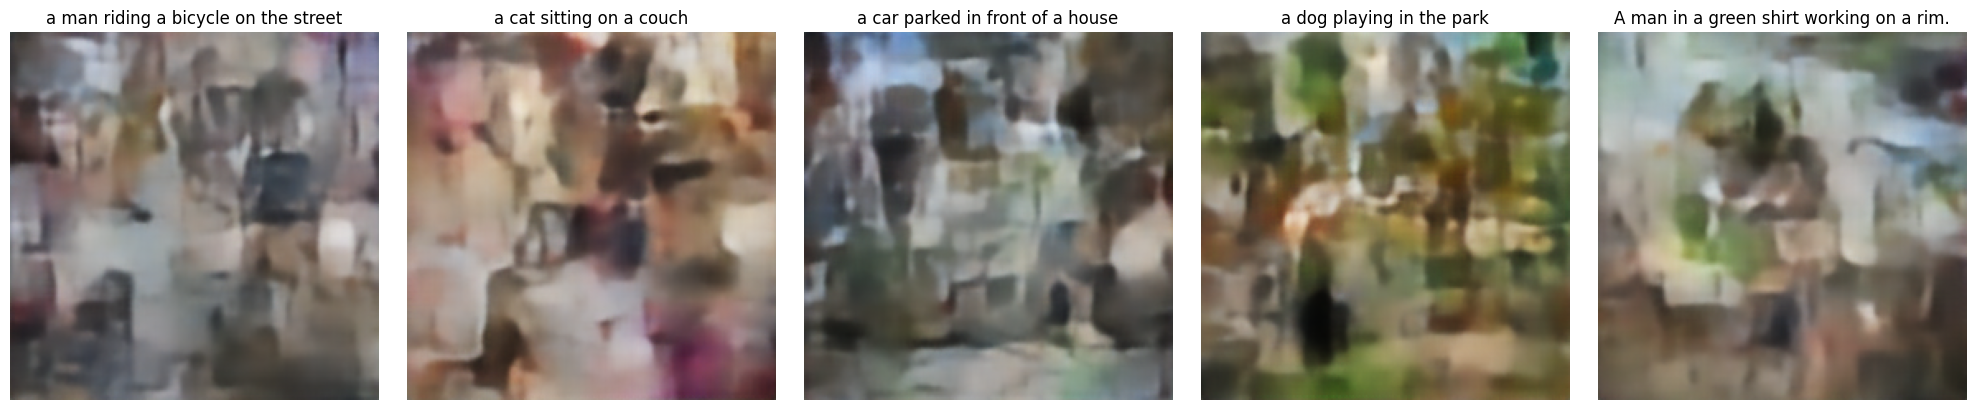

In [17]:


model = CVAE(condition_dim=condition_dim, latent_dim=latent_dim).to(device)


model.load_state_dict(torch.load("model_250.pth"))
model.eval()  
print("Model loaded successfully!")


model.eval()
def generate_from_text(model, texts):
    with torch.no_grad():
        text_features = torch.stack([dataset.extract_text_features(text) for text in texts]).to(device)
        print(text_features)
        z = torch.randn(len(texts), latent_dim).to(device)
        print(z.size())
        samples = model.decoder(z, text_features).view(-1, 3, 224, 224).cpu()
        print(samples.size())

        fig, axs = plt.subplots(1, len(texts), figsize=(len(texts) * 4, 4))
        for i, ax in enumerate(axs):
            ax.imshow(samples[i].permute(1, 2, 0))  
            ax.axis('off')
            ax.set_title(texts[i])

        plt.tight_layout()
        plt.show()


test_texts = [
    "a man riding a bicycle on the street",
    "a cat sitting on a couch",
    "a car parked in front of a house",
    "a dog playing in the park",
    "A man in a green shirt working on a rim."
]
# test_texts = ["A small closed toilet in a cramped space.",
# "A white bread sandwich on plate filled with ham and lettuce",
# "A bicycle is locked up to a post",
# "Two cats are sitting on a pair of shoes outdoors."]
generate_from_text(model, test_texts)

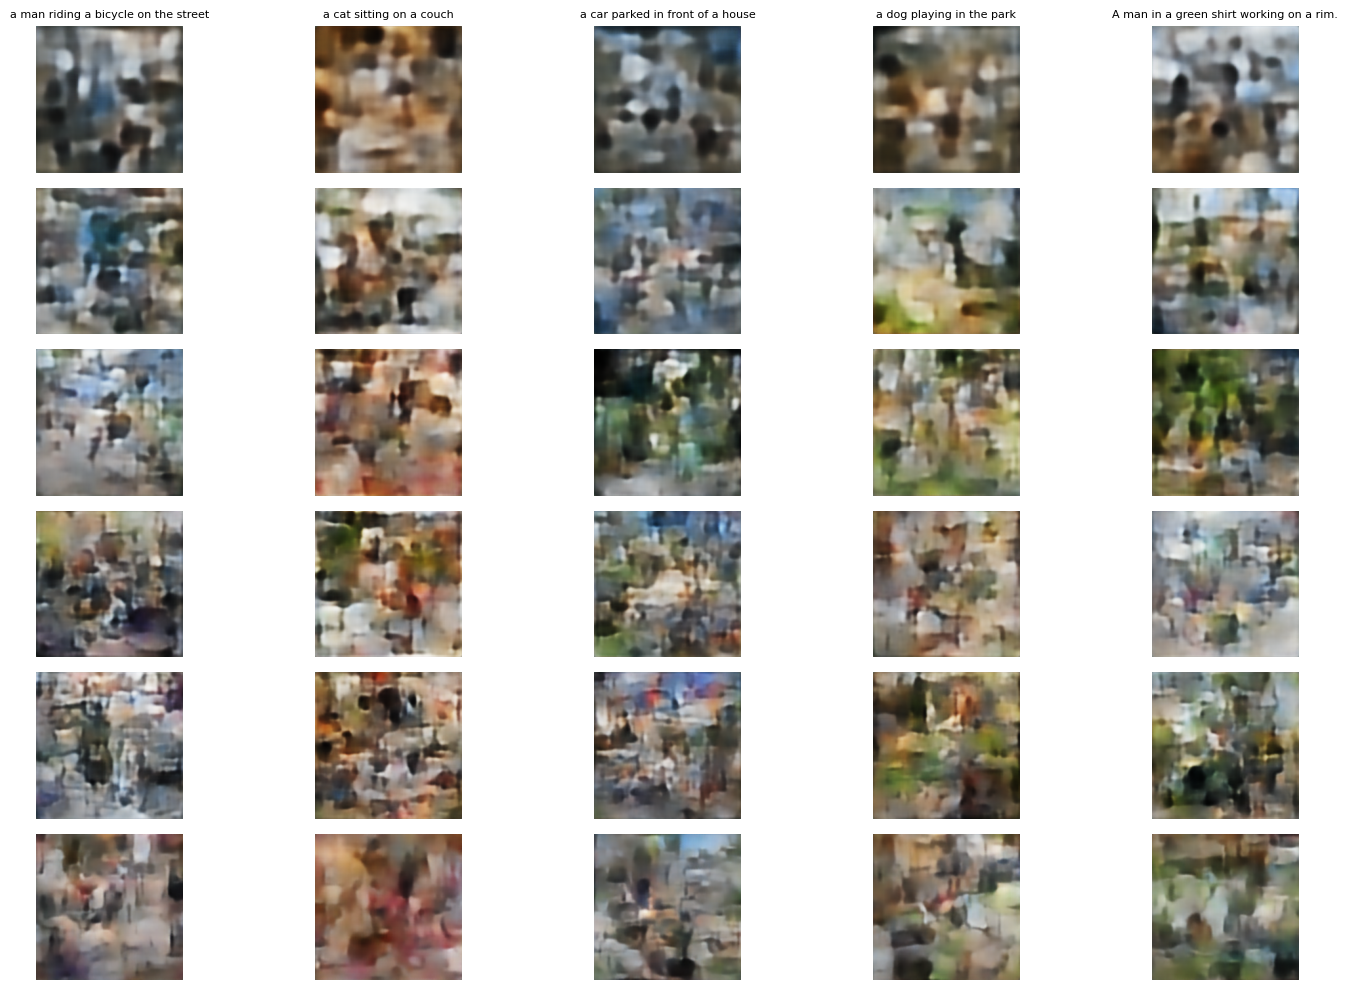

In [14]:
# combine all models

models = ["model", "model_50", "model_100", "model_150", "model_200", "model_250"]

test_texts = [
    "a man riding a bicycle on the street",
    "a cat sitting on a couch",
    "a car parked in front of a house",
    "a dog playing in the park",
    "A man in a green shirt working on a rim."
]

def generate_from_text(model, texts):
    with torch.no_grad():
        text_features = torch.stack([dataset.extract_text_features(text) for text in texts]).to(device)
        z = torch.randn(len(texts), latent_dim).to(device)
        samples = model.decoder(z, text_features).view(-1, 3, 224, 224).cpu()
        return samples

#
fig, axs = plt.subplots(len(models), len(test_texts), figsize=(15, 10))

for row, model_name in enumerate(models):

    model = CVAE(condition_dim=condition_dim, latent_dim=latent_dim).to(device)
    model.load_state_dict(torch.load(f"{model_name}.pth"))
    model.eval()

    generated_images = generate_from_text(model, test_texts)

    for col, text in enumerate(test_texts):
        ax = axs[row, col]
        ax.imshow(generated_images[col].permute(1, 2, 0))
        ax.axis('off')
        
        if col == 0:
            ax.set_ylabel(model_name, fontsize=10) 
        if row == 0:
            ax.set_title(text, fontsize=8) 

plt.tight_layout()
plt.show()

In [ ]:
output_path = "generated_images.png"
fig.savefig(output_path, dpi=600) 
plt.close(fig)

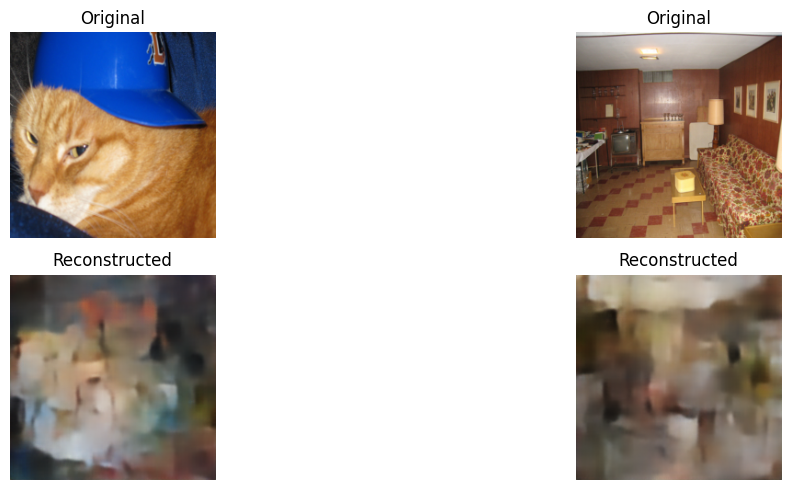

In [18]:
import matplotlib.pyplot as plt

# Function to visualize original and reconstructed images
def plot_reconstructed_images(original_images, reconstructed_images, num_images=2):
    """
    Plot original and reconstructed images side by side.

    Args:
        original_images (torch.Tensor): Batch of original images.
        reconstructed_images (torch.Tensor): Batch of reconstructed images.
        num_images (int): Number of images to display.
    """
    # Detach tensors and move to CPU for plotting
    original_images = original_images.detach().cpu().permute(0, 2, 3, 1)  # Move channels to last
    reconstructed_images = reconstructed_images.detach().cpu().permute(0, 2, 3, 1)
    
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    for i in range(num_images):
        # Plot original image
        axes[0, i].imshow(original_images[i].squeeze(), cmap=None)
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")
        
        # Plot reconstructed image
        axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap = None)
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")
    
    plt.tight_layout()
    plt.show()

# Extract one batch from val_loader
for batch_idx, (images, text_features) in enumerate(val_loader):
    images, text_features = images.to(device), text_features.to(device)
    recon_batch, mu, logvar = model(images, text_features)  # Forward pass
    break

# Plot the original and reconstructed images
plot_reconstructed_images(images, recon_batch)

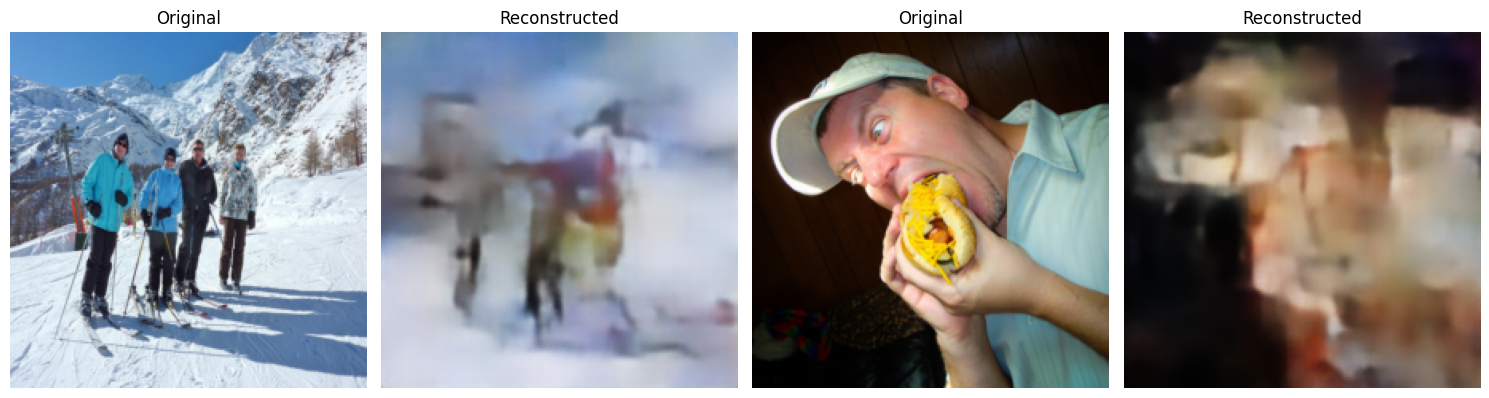

In [32]:
model = CVAE(condition_dim=condition_dim, latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load("model_250.pth"))
model.eval()  

def plot_reconstructed_images_one_row(original_images, reconstructed_images, num_images=2):
    """
    Plot original and reconstructed images in one row.

    Args:
        original_images (torch.Tensor): Batch of original images.
        reconstructed_images (torch.Tensor): Batch of reconstructed images.
        num_images (int): Number of original-reconstructed pairs to display.
    """
    # Detach tensors and move to CPU for plotting
    original_images = original_images.detach().cpu().permute(0, 2, 3, 1)  # Move channels to last
    reconstructed_images = reconstructed_images.detach().cpu().permute(0, 2, 3, 1)
    
    fig, axes = plt.subplots(1, num_images * 2, figsize=(15, 5))  # One row, 2 columns per pair
    for i in range(num_images):
        # Plot original image (1 and 3)
        axes[i * 2].imshow(original_images[i].squeeze(), cmap=None)
        axes[i * 2].axis('off')
        axes[i * 2].set_title("Original")

        # Plot reconstructed image (2 and 4)
        axes[i * 2 + 1].imshow(reconstructed_images[i].squeeze(), cmap=None)
        axes[i * 2 + 1].axis('off')
        axes[i * 2 + 1].set_title("Reconstructed")
    
    plt.tight_layout()
    plt.show()

# Extract one batch from val_loader
for batch_idx, (images, text_features) in enumerate(val_loader):
    images, text_features = images.to(device), text_features.to(device)
    recon_batch, mu, logvar = model(images, text_features)  # Forward pass
    break

# Plot the original and reconstructed images in one row
plot_reconstructed_images_one_row(images, recon_batch, num_images=2)

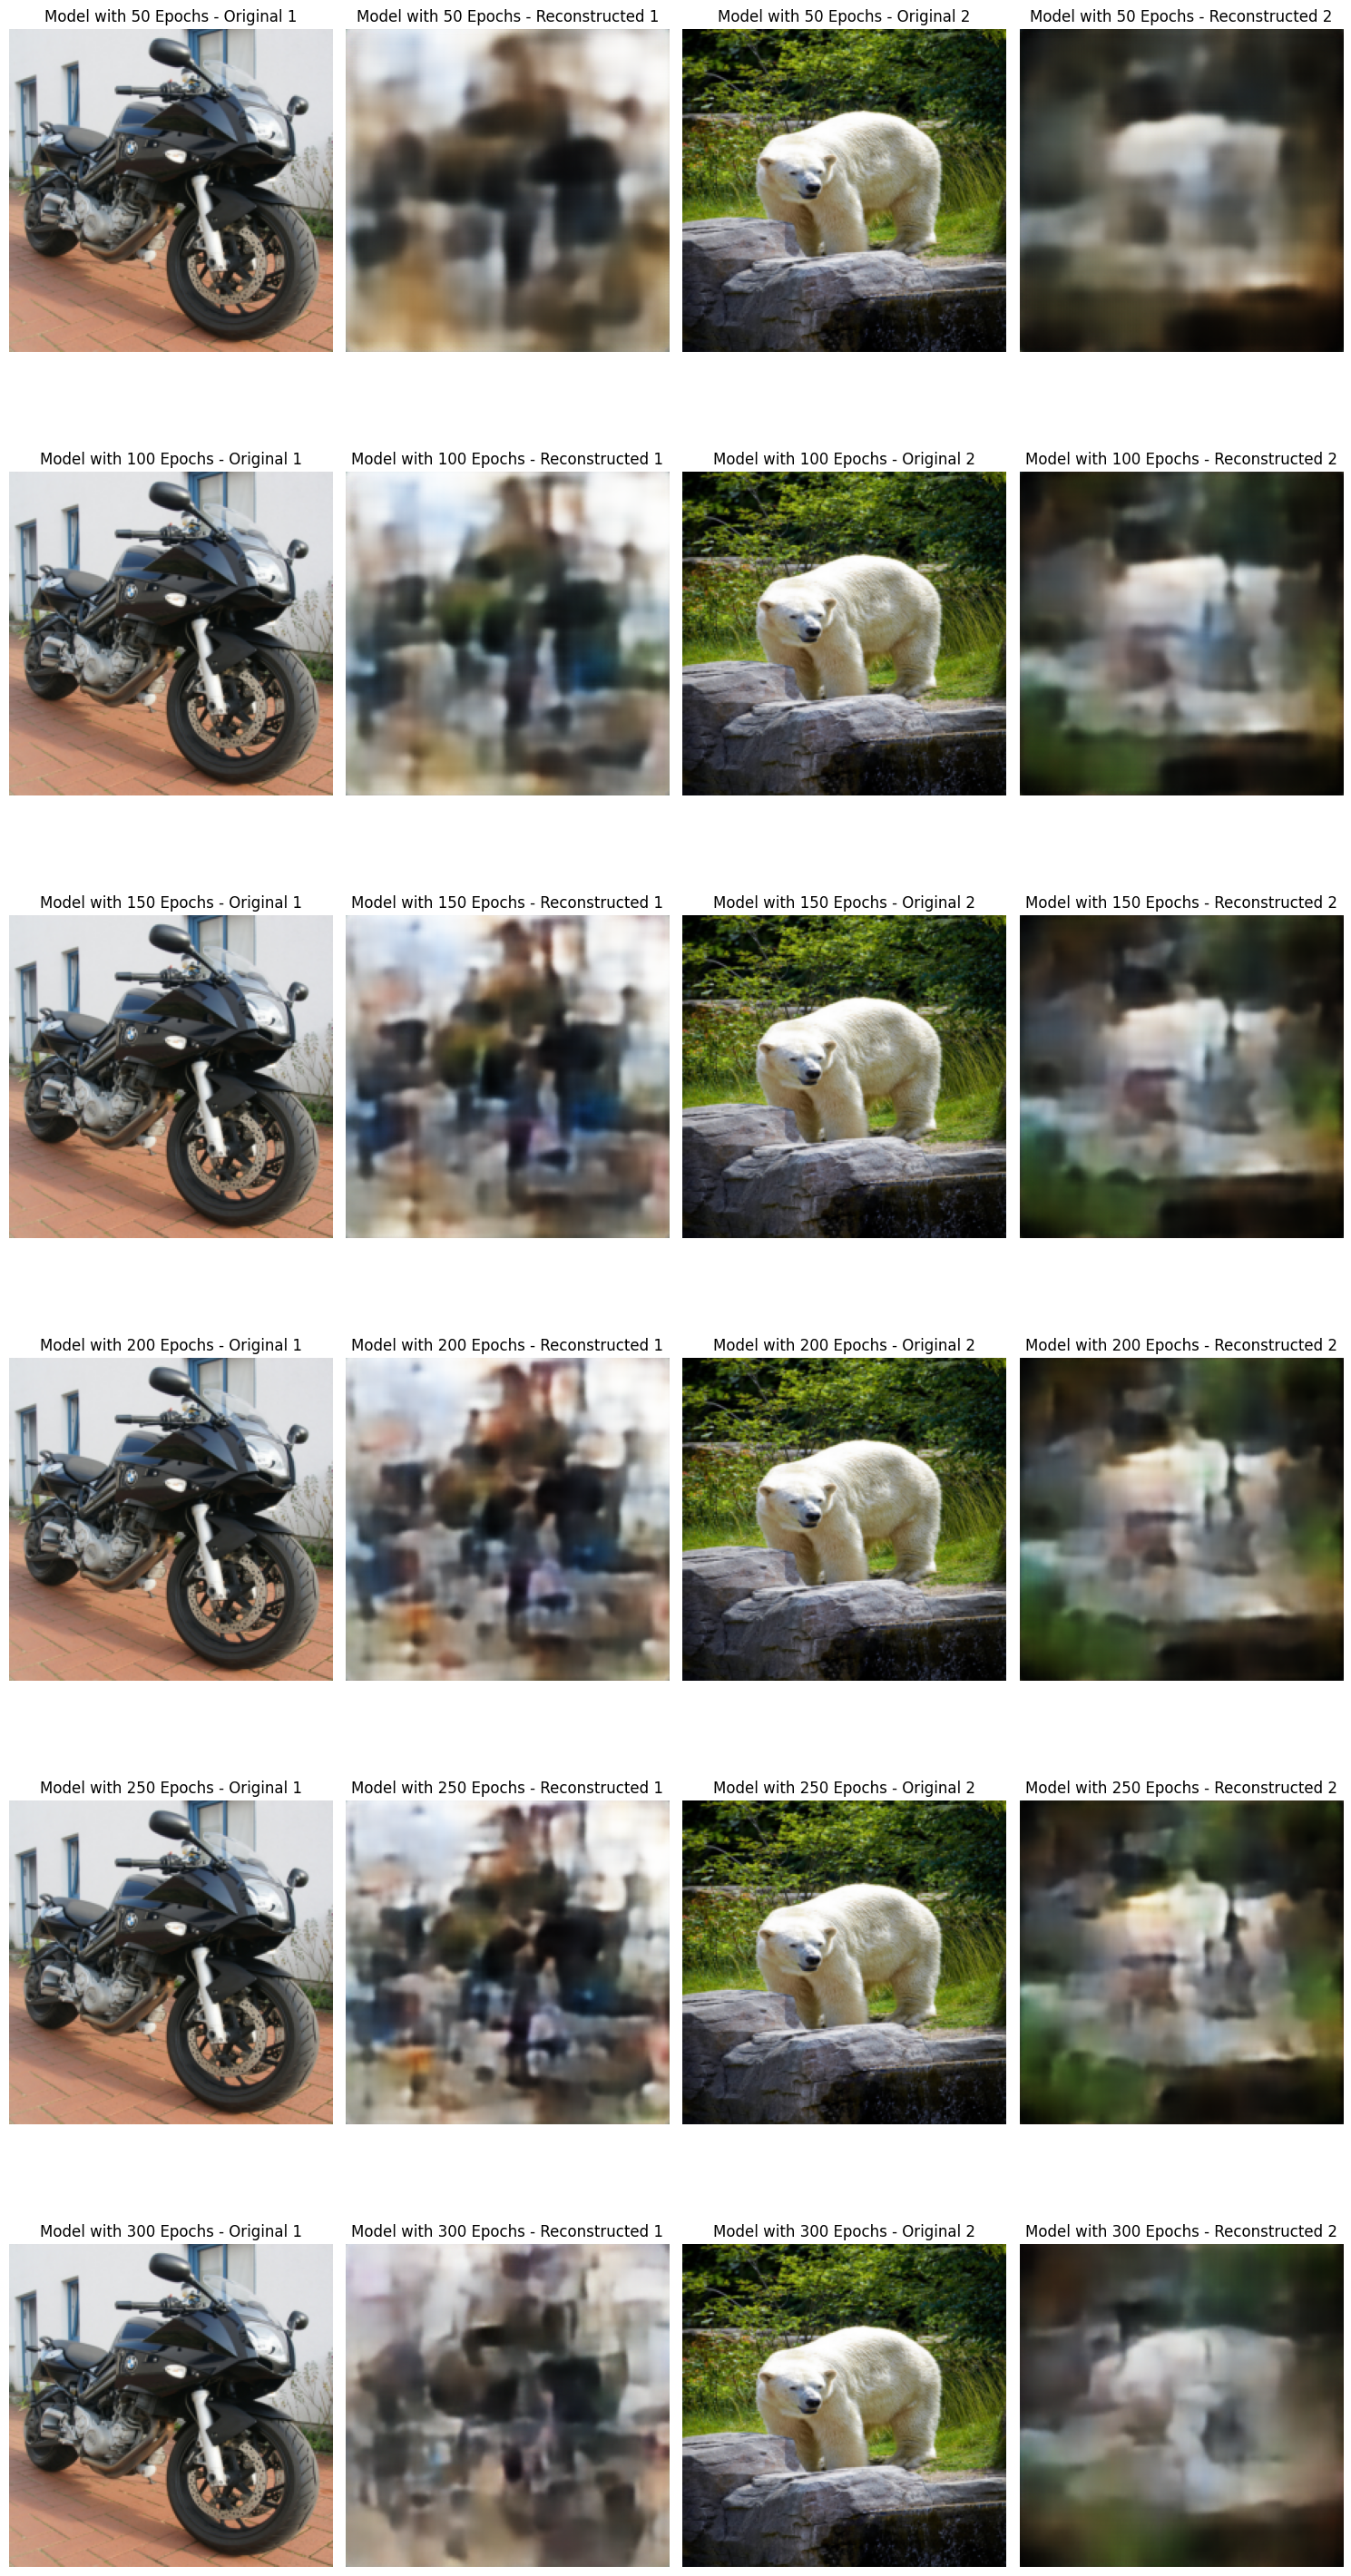

In [43]:
def plot_all_models_reconstructed_images(models, val_loader, device):
    """
    Plot original and reconstructed images for multiple models in a large figure using the same batch of images.

    Args:
        models (list of str): List of model file paths to load.
        val_loader (DataLoader): DataLoader to provide input images and conditions.
        device (torch.device): Device to use for computation.
    """
    # Extract a single batch from val_loader for all models to use
    for batch_idx, (images, text_features) in enumerate(val_loader):
        images, text_features = images.to(device), text_features.to(device)
        break  # Only need one batch

    # Ensure batch size is 2
    assert images.shape[0] == 2, "Batch size must be 2 for this visualization."

    # Prepare a large figure with rows for each model
    num_models = len(models)
    fig, axes = plt.subplots(num_models, 4, figsize=(15, num_models * 5))  # 4 columns: original1, reconstructed1, original2, reconstructed2
    
    for row, model_path in enumerate(models):
        # Load the model
        model = CVAE(condition_dim=condition_dim, latent_dim=latent_dim).to(device)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        
        # Perform forward pass to get reconstructed images
        recon_batch, mu, logvar = model(images, text_features)
        
        # Detach tensors and move to CPU for plotting
        original_images = images.detach().cpu().permute(0, 2, 3, 1)  # Move channels to last
        reconstructed_images = recon_batch.detach().cpu().permute(0, 2, 3, 1)
        
        # Plot original and reconstructed images in one row
        # Original image 1
        axes[row, 0].imshow(original_images[0].squeeze(), cmap=None)
        axes[row, 0].axis('off')
        axes[row, 0].set_title(f"Model with {(row + 1)*50} Epochs - Original 1")
        
        # Reconstructed image 1
        axes[row, 1].imshow(reconstructed_images[0].squeeze(), cmap=None)
        axes[row, 1].axis('off')
        axes[row, 1].set_title(f"Model with {(row + 1)*50} Epochs - Reconstructed 1")
        
        # Original image 2
        axes[row, 2].imshow(original_images[1].squeeze(), cmap=None)
        axes[row, 2].axis('off')
        axes[row, 2].set_title(f"Model with {(row + 1)*50} Epochs - Original 2")
        
        # Reconstructed image 2
        axes[row, 3].imshow(reconstructed_images[1].squeeze(), cmap=None)
        axes[row, 3].axis('off')
        axes[row, 3].set_title(f"Model with {(row + 1)*50} Epochs - Reconstructed 2")
    
    plt.tight_layout()
    plt.savefig("reconstruction.png", bbox_inches='tight', dpi=600) 
    plt.show()

# List of model paths
model_paths = ["model.pth", "model_50.pth", "model_100.pth", "model_150.pth", "model_200.pth", "model_250.pth"]

# Plot results for all models using the same batch of images
plot_all_models_reconstructed_images(model_paths, val_loader, device)